# Basic Model Operations

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

**Note:** This is not the table of contents. Just the model training process minimum requirements cheat sheet.

1. Acquire Data
2. Build Model
    1. Subclass `nn.Module`
    2. Set parameters or layers
    3. Override forward() for forward pass
3. Set Loss Function
4. Set Optimizer
5. Train Loop
    1. Zero gradients with `optimizer.zero_grad()`
    2. Make predictions `y_pred = model(inputs)`
    3. Compute loss with `loss = loss_fn(y_preds, labels)`
    4. Compute gradient with `loss.backward()`
    5. Adjust weights with `optimizer.step()`

## 1. Acquire Data

- To observe how model weights adjusts over time we will set some known parameters.
- Linear Regression will be used to model due to its simplicity. That way, a nice line will be created. With that we can compare the train, test and prediction results

**Linear Regression ->** `y = weight * X + bias`

In [2]:
# This will be ideal parameters to reach.
weight = 0.6
bias = 0.4

# Generate data - X -> features, y -> labels
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1) # add one dimension to turn into column vector.
y = weight * X + bias

X[:5], X.shape, y[:5], y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 torch.Size([50, 1]),
 tensor([[0.4000],
         [0.4120],
         [0.4240],
         [0.4360],
         [0.4480]]),
 torch.Size([50, 1]))

In [3]:
train_size = 0.8 # We are aiming for 80% train and 20% test data.
train_test_split = int(len(X) * train_size)

X_train, y_train = X[:train_test_split], y[:train_test_split]
X_test, y_test = X[train_test_split:], y[train_test_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data
  plt.scatter(test_data, test_labels, c="#FFA500", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

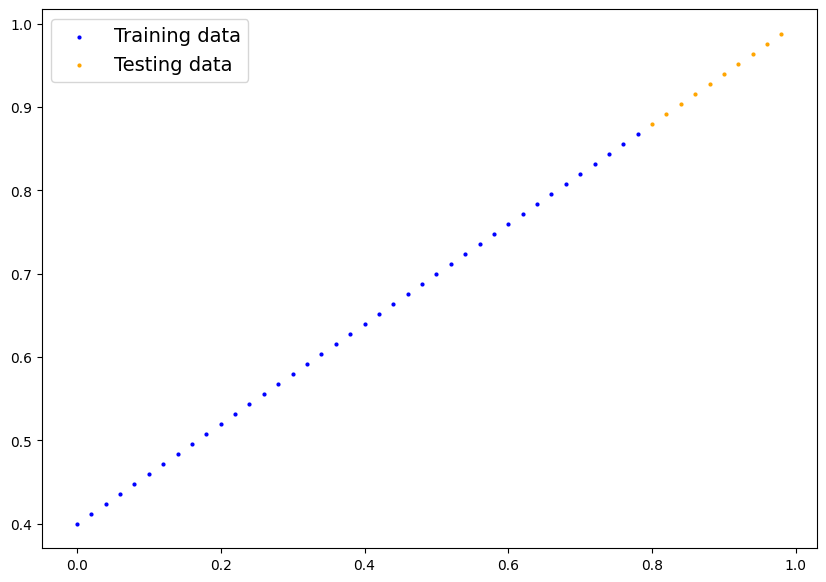

In [5]:
plot_predictions()

## 2. Build the Model

1. Subclass `nn.Module`
2. Set parameters or layers
3. Override forward() for forward pass

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Data has one weight and one bias so one random tensor is required.
        # https://pytorch.org/docs/main/generated/torch.randn.html
        self.weight = nn.Parameter(data=torch.randn(1, dtype=torch.float),
                                    requires_grad=True)
        
        self.bias = nn.Parameter(data=torch.randn(1, dtype=torch.float),
                                    requires_grad=True)
    
    # Function for the forward pass.
    # "x" marks the input. 
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

### 2.1. Checking Inner Values of a Model

Current model is a linear regression model having two parameters called weight and bias. Observing such data is easy enough but when images or multidimensional matrices involved, this will be less and less useful.

1) `model.parameters()`
2) `model.state_dict()`

In [7]:
torch.manual_seed(7)
linear_model = LinearRegressionModel()

# parameters() will return a generator object
list(linear_model.parameters())

[Parameter containing:
 tensor([-0.1468], requires_grad=True),
 Parameter containing:
 tensor([0.7861], requires_grad=True)]

In [8]:
linear_model.state_dict()

OrderedDict([('weight', tensor([-0.1468])), ('bias', tensor([0.7861]))])

## 3. Making Predictions

- A model can make predictions without being trained with just sending the input values to the model. 
- This calls the forward() method in the background.
- Notice that predictions have another value called grad_fn.
- This is the direct cause of a tensor having `requires_grad=True` as parameter.
- PyTorch tracks every forward operation on a tensor if `requires_grad` parameter is set to `True`. This action is used by PyTorch in the backward pass.
- By default gradient tracking is False.
- Gradient tracking is not useful in all scenarios. Like making predictions/running inference actively. In smaller datasets might not affect performance much but on larger datasets disabling tracking can lower prediction times. Which is desired.

In [9]:
y_preds = linear_model(X_test)

y_preds

tensor([[0.6687],
        [0.6658],
        [0.6628],
        [0.6599],
        [0.6570],
        [0.6540],
        [0.6511],
        [0.6482],
        [0.6452],
        [0.6423]], grad_fn=<AddBackward0>)

In [10]:
# https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html
# torch.no_grad() could be used here too.
# Stops gradient tracking.
with torch.inference_mode():
    y_preds = linear_model(X_test)

y_preds

tensor([[0.6687],
        [0.6658],
        [0.6628],
        [0.6599],
        [0.6570],
        [0.6540],
        [0.6511],
        [0.6482],
        [0.6452],
        [0.6423]])

Can be seen that predictions are quite off from the ground truth values. This is because calculations are run with wrong weight and bias values. That's why even the slope of predictions are wrong.

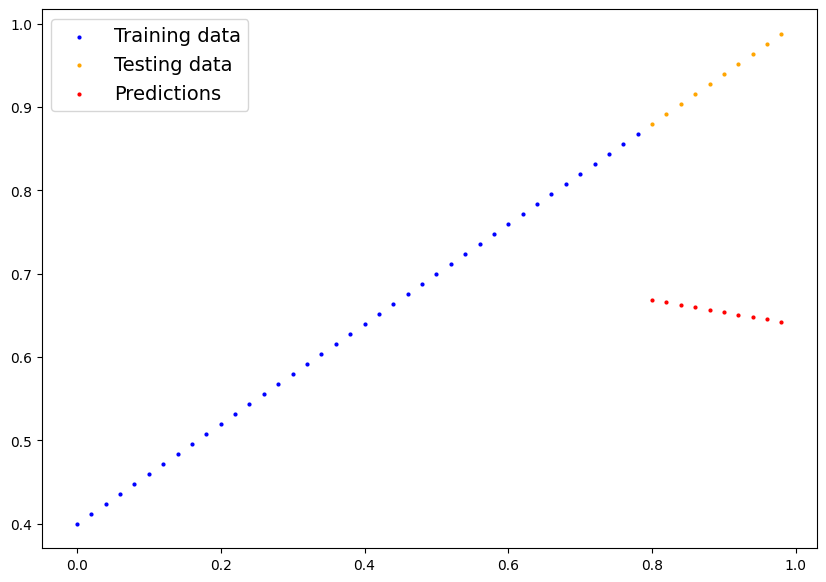

In [11]:
plot_predictions(predictions=y_preds)

## 4. Training 
*Eye of the Tiger intensifies...*

- Model is not representing the data right now.
- In order to achieve better representation of the input data a process called **training** is applied to the model.
- The idea is starting from **some** parameters (generally random or set according to some distribution) and ending up with **THE** parameters to make predictions *ideally** in par with ground truth values.

**Why ideally? Prediction model accuracy is generally not 100%. A prediction is, well, a prediction. Not the actual, real calculated value of the input. An ML/DL model approaches to the ideal.*

### 4.1. Calculating the Wrongness
- In order to achieve ideal predictions, first we need to know how far are model's predictions from ground truth.
- This calculation can be performed with a **loss function**.
- There are many loss functions proposed for different solutions. PyTorch has them built-in but how to choose?

**Thinking about our problem:** Our model is a regression model, specifically a linear regression model. 
- So we need to predict a number. This is the first step.
- Secondly if we look again to see the predictions on the plot we can clearly see that there is a distance between actual and predicted values. Our goal is to minimize that distance for each input-prediction pair.
- [Docs: Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Cool Video about loss functions](https://youtu.be/v_ueBW_5dLg?feature=shared)

### 4.2. Stepping Away from the Wrong
**Loss is calculated now what?** Model parameters should be adjusted. Who gonna do it? Well, you. Will define it at least. But **optimizer** actually will. 
- [The loss function is the guide to the terrain, telling the optimizer when it’s moving in the right or wrong direction.](https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html)
- Terrain is the gradient, loss is your compass and optimizer is your model's legs in this scenario.
- That is why choosing the correct loss function plays a crucial role. Wrong directions lead to stray from the path.
- Choosing the optimizer is not a difficult task but requires a bit of knowledge among with some trial and error. 
- PyTorch has optimizers built-in.
- [Docs: Optimizers](https://pytorch.org/docs/stable/optim.html) 

**A very important hyperparameter, Learning Rate:** Optimizer will adjust the model parameters but in respect to what? Apples? Bananas? No, making adjustments simply is not done in one go. 
- Instead step by step the ideal parameters are approached. 
- Learning rate is the magnitude of that step. 
- Too low, model learns so slowly or model stucks on local minimums easily. 
- Too high, model overshoots and misses the plateau.
- Can be picked with trial and error. Generally, start with default values then alter if needed.

In [12]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer
# SGD - Stochastic Gradient Descent. Literally the thing we want to achieve. The gradient descent.
optimizer = torch.optim.SGD(params=linear_model.parameters(),
                            lr=0.01)

print("Loss Function:", loss_fn)
print("optimizer:", optimizer)

Loss Function: L1Loss()
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### 4.3. Training Loop

*Some train a day, keeps the HR away.*

While looping the data:
1) Set model to train mode - Set flag for training*
1) Make sure gradient is cleared** - Optimizer Zero Grad
2) Make predictions - Forward Pass
3) Calculate how wrong you are - Loss Function
4) From back to start calculate the gradient of each parameter - Backpropagation
5) Adjust model parameters - Optimizer Step

**[Train and Eval Mode Differences](https://www.geeksforgeeks.org/what-does-model-train-do-in-pytorch/)*

***[It is beneficial to zero out gradients when building a neural network. This is because by default, gradients are accumulated in buffers (i.e, not overwritten) whenever `.backward()` is called.](https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html)*

In [13]:
torch.manual_seed(7)
EPOCHS = 200
loss_history = []

for epoch in range(EPOCHS):
    # 1) Set model to train mode
    linear_model.train()

    # 2) Clear the gradients
    optimizer.zero_grad()

    # 3) Make predictions
    y_pred = linear_model(X_train)

    # 4) Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # collecting a little bit of data for graphics 
    loss_history.append(loss)

    # 5) Backpropagation
    loss.backward()

    # 6) Adjust model parameters
    optimizer.step()

    # take model out of train mode.
    linear_model.eval()

In [14]:
linear_model.state_dict()

OrderedDict([('weight', tensor([0.1679])), ('bias', tensor([0.5816]))])

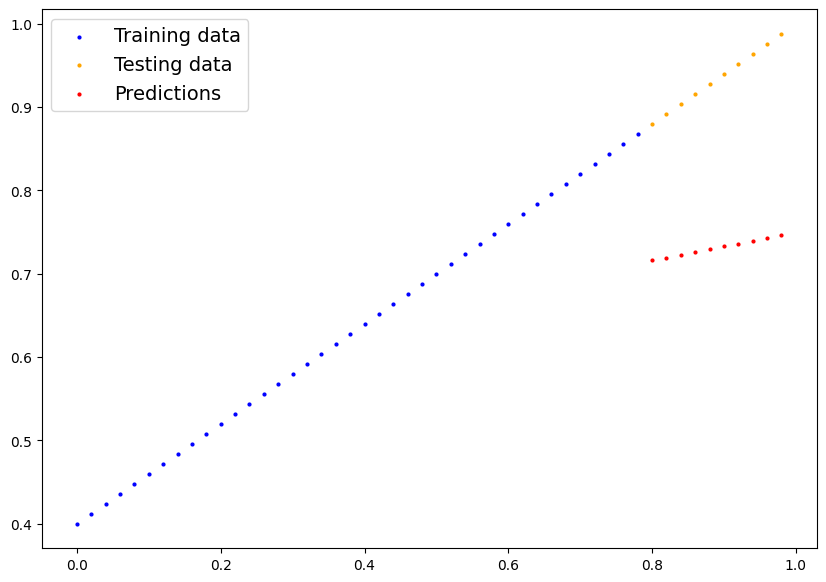

In [15]:
with torch.inference_mode():
    preds = linear_model(X_test)

plot_predictions(predictions=preds)

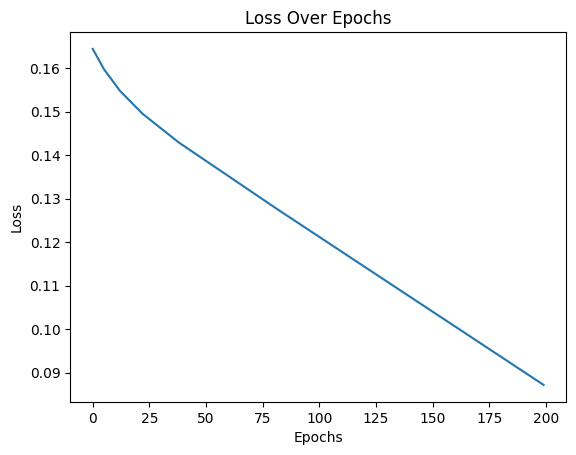

In [16]:
# type(loss_history[0]) -> torch.Tensor
# Can not convert torch tensor that requires grad to numpy before detaching.
with torch.no_grad():
    plt.plot(loss_history)
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

## 5. Testing Loop

- Similar to training loop but for test data.
- Actually same training loop but testing model with data have not seen before.
- More like validation.

In [17]:
torch.manual_seed(7)
EPOCHS = 250

epoch_history = []
loss_history = []
test_loss_history = []

for epoch in range(1, EPOCHS+1):
    # 1) Set model to train mode
    linear_model.train()

    # 2) Clear the gradients
    optimizer.zero_grad()

    # 3) Make predictions
    y_pred = linear_model(X_train)

    # 4) Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 5) Backpropaagtion
    loss.backward()

    # 6) Adjust model parameters
    optimizer.step()

    # take model out of train mode.
    linear_model.eval()

    with torch.inference_mode():
        test_pred = linear_model(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    # can be customized. For now just print losses every epoch.
    if epoch % 25 == 0:
        epoch_history.append(epoch)
        loss_history.append(loss)
        test_loss_history.append(test_loss)
        print(f"Epoch: {epoch:>3} | Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch:  25 | Loss: 0.0786 | Test Loss: 0.1829
Epoch:  50 | Loss: 0.0700 | Test Loss: 0.1629
Epoch:  75 | Loss: 0.0615 | Test Loss: 0.1429
Epoch: 100 | Loss: 0.0529 | Test Loss: 0.1229
Epoch: 125 | Loss: 0.0443 | Test Loss: 0.1029
Epoch: 150 | Loss: 0.0357 | Test Loss: 0.0829
Epoch: 175 | Loss: 0.0271 | Test Loss: 0.0629
Epoch: 200 | Loss: 0.0185 | Test Loss: 0.0423
Epoch: 225 | Loss: 0.0099 | Test Loss: 0.0223
Epoch: 250 | Loss: 0.0014 | Test Loss: 0.0016


Little bit more training and parameters really close to what originally set as known paramters.

In [18]:
linear_model.state_dict()

OrderedDict([('weight', tensor([0.5952])), ('bias', tensor([0.4026]))])

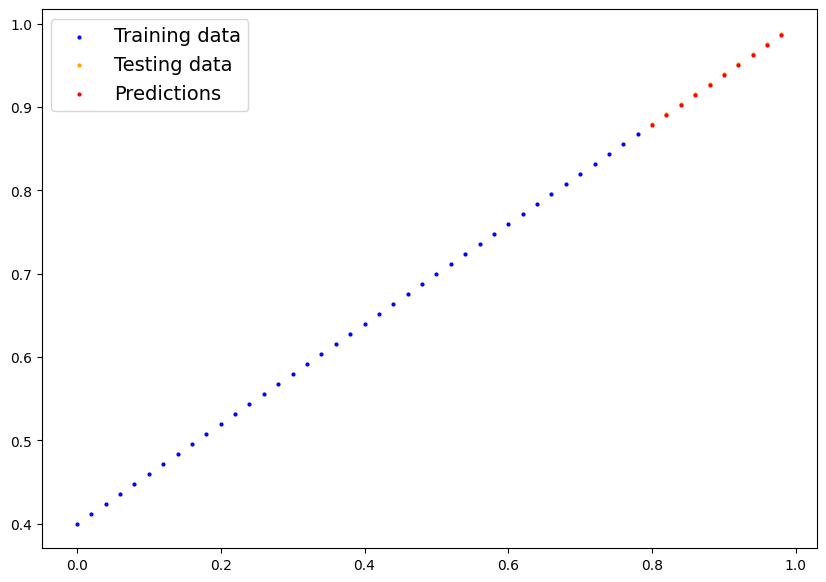

In [19]:
with torch.inference_mode():
    preds = linear_model(X_test)

plot_predictions(predictions=preds)

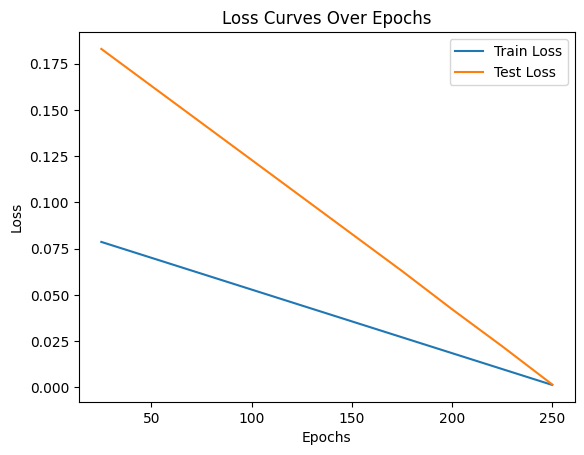

In [20]:
# Not exacly a curve but what's important is strong decline in loss
# along with test and train losses reach to similar value.
with torch.inference_mode():
    plt.plot(epoch_history, loss_history, label="Train Loss")
    plt.plot(epoch_history, test_loss_history, label="Test Loss")
    plt.title("Loss Curves Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## 6. Saving Model

[Saving and Loading Models by PyTorch ⬆](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

**Use Cases:**
- Deploying after training.
- Sharing.
- Generating a checkpoint.
- `torch.save()` -> save the model serialized with python pickle format.
- `torch.load()` -> load the model by deserialzing it.
- `torch.nn.Module.load_state_dict()` -> load saved model's state dictionary.

In [21]:
# https://pytorch.org/docs/stable/generated/torch.save.html#torch.save
# Model can be saved just by giving it a name and a path.
# But I have not used pathlib before so let's use it.

from pathlib import Path

MODEL_PATH = Path("models")
# https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
# .mkdir(): make directory
# -parents=True: create parent files if needed.
# -exist_ok=True: Do not raise error if file exists already.
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "linear_model.pth"

# A syntax usable in pathlib denotes a path structure.
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Model is saving to {MODEL_SAVE_PATH}")

# Saving the state dictionary is recommended since only paramters are saved
# and can be loaded directly to the model later. 
# Saving the entire model can break th code in various ways due to 
# pickle's inner working.
torch.save(obj=linear_model.state_dict(), f=MODEL_SAVE_PATH)

Model is saving to models\linear_model.pth


## 7. Load Model

In [23]:
# Load the saved weights on a new instance.
loaded_model = LinearRegressionModel()
print("Weights before loading weights: ", loaded_model.state_dict())

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))
print("Weights after loading weights: ", loaded_model.state_dict())

Weights before loading weights:  OrderedDict([('weight', tensor([0.9468])), ('bias', tensor([-1.1143]))])
Weights after loading weights:  OrderedDict([('weight', tensor([0.5952])), ('bias', tensor([0.4026]))])


In [25]:
# Making predictions with both models.
linear_model.eval()
with torch.inference_mode():
    y_preds = linear_model(X_test)

loaded_model.eval()
with torch.inference_mode():
    loaded_preds = loaded_model(X_test)

y_preds == loaded_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 8. Extra

### 8.1. Setting-up Device Agnostic Code

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

### 8.2. Re-writing Linear Regression Model with PyTorch Layers

In [81]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self,):
        super().__init__()

        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # Input 1 value: X, output 1 value: y 
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1, 
                                      bias=True) # Dense layer if you are coming from TensorFlow.
    
    def forward(self, x:torch.Tensor) -> torch.tensor:
        return self.linear_layer(x)

In [96]:
torch.manual_seed(77)
linear_model_v2 = LinearRegressionModelV2()

# Can have different weights even with same seed due to PyTorch implementation.
linear_model_v2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.4162]])),
             ('linear_layer.bias', tensor([-0.4286]))])

### 8.3. Moving Model to GPU

In [97]:
next(linear_model_v2.parameters()).device

device(type='cpu')

In [98]:
linear_model_v2.to(device)

next(linear_model_v2.parameters()).device

device(type='cuda', index=0)

### 8.4. Training

**Requirements:**
- Loss function
- Optimizer

**Optional Data Collection:**
- Epochs (Not needed but good for binning)
- Train loss
- Test loss

**Train Algorithm:**
- set model to train mode
- zero_grad
- make predictions
- calculate loss
- backward pass on loss
- optimizer step

**Optional Test Loop:**
- set model to eval mode
- set torch in inference mode
- make predictions on test set
- calculate loss of test set
- print epoch, train loss, test loss

In [99]:
# choose loss function
loss_fn = nn.L1Loss()

# choose optimizer
optimizer = torch.optim.Adam(params=linear_model_v2.parameters(),
                             lr=0.01)

# Model is in GPU but train and test data is not will throw an error.
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# collecting data
EPOCHS = 200
# a bit controversial but more that enough here
PAD = len(str(EPOCHS))

epoch_history = []
train_loss_history = []
test_loss_history = []

# train loop
torch.manual_seed(7)
for epoch in range(1, EPOCHS + 1):
    # set model to train mode
    linear_model_v2.train()

    optimizer.zero_grad()

    y_preds = linear_model_v2(X_train)
    
    loss = loss_fn(y_preds, y_train)
    loss.backward()
    
    optimizer.step()

    # test
    if epoch % 25 == 0:
        # set model to eval mode
        linear_model_v2.eval()

        with torch.inference_mode():
            test_preds = linear_model_v2(X_test)
            test_loss = loss_fn(test_preds, y_test)

        epoch_history.append(epoch)
        train_loss_history.append(loss)
        test_loss_history.append(test_loss)

        print(f"Epoch: {epoch:>{PAD}} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch:  25 | Train Loss: 0.89135 | Test Loss: 1.26053
Epoch:  50 | Train Loss: 0.54385 | Test Loss: 0.78803
Epoch:  75 | Train Loss: 0.19635 | Test Loss: 0.31553
Epoch: 100 | Train Loss: 0.03741 | Test Loss: 0.01455
Epoch: 125 | Train Loss: 0.01231 | Test Loss: 0.01302
Epoch: 150 | Train Loss: 0.00228 | Test Loss: 0.00299
Epoch: 175 | Train Loss: 0.00015 | Test Loss: 0.00090
Epoch: 200 | Train Loss: 0.00179 | Test Loss: 0.00369


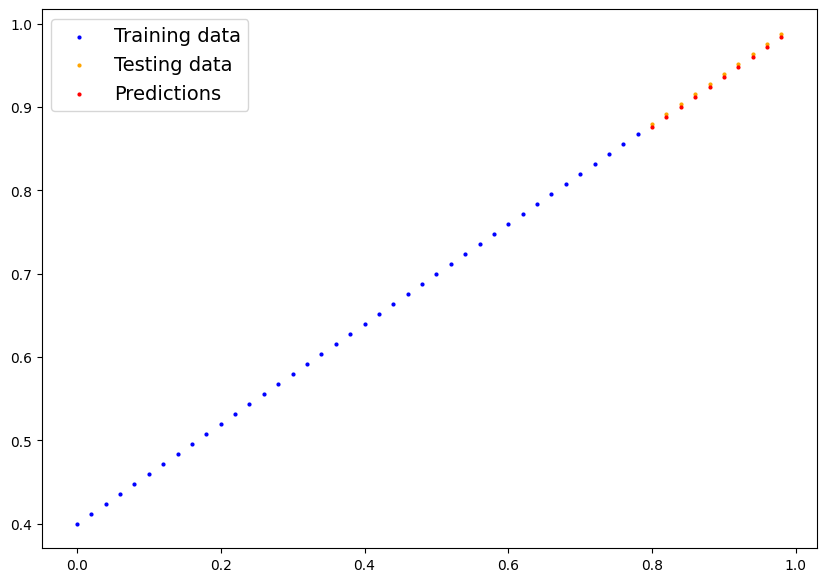

In [100]:
linear_model_v2.eval()

with torch.inference_mode():
    y_hat = linear_model_v2(X_test)
plot_predictions(predictions=y_hat.cpu())